In [1]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-07-19 14:37:14.100261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 14:37:14.100368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 14:37:14.377814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [1]:
import glob

# Define the path pattern
data_folder = "/kaggle/input/trainingdata/*.csv"

# Use glob to get a list of all files matching the pattern
csv_files = glob.glob(data_folder)

# Print the list of files to verify
print("CSV files found:", csv_files)


CSV files found: ['/kaggle/input/trainingdata/log_49_2024-2-26-12-50-54.csv', '/kaggle/input/trainingdata/log_54_2024-2-26-13-10-12.csv', '/kaggle/input/trainingdata/log_51_2024-2-26-12-53-18.csv', '/kaggle/input/trainingdata/log_53_2024-2-26-13-02-02.csv', '/kaggle/input/trainingdata/log_50_2024-2-26-12-51-48.csv', '/kaggle/input/trainingdata/log_48_2024-2-26-12-34-30.csv']


In [2]:
n_past = 200
n_future = 50
batch_size = 32  # Set batch size
epochs = 10

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Reshape, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import GlorotUniform
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import glob

# Define the model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(8, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(), input_shape=input_shape))
    model.add(Dropout(0.2))  # Increased dropout rate
    model.add(BatchNormalization())  # Added batch normalization
    model.add(LSTM(8, activation='relu', return_sequences=False, kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform()))
    model.add(Reshape((n_future, input_shape[1])))
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse', metrics=['mae'])  # Added MAE as a metric
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)


cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    if cnt == 1:
        # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt -= 1
    
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
print("Processing complete.")


2024-07-21 10:59:56.827824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 10:59:56.827933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 10:59:57.001184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processing /kaggle/input/trainingdata/log_49_2024-2-26-12-50-54.csv


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
  2/285 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 2.2993 - mae: 0.8339

I0000 00:00:1721559618.989422     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721559619.025153     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - loss: 1.4103 - mae: 0.6721 - val_loss: 0.3033 - val_mae: 0.3849 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.6541 - mae: 0.5183 - val_loss: 0.3199 - val_mae: 0.4101 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.5738 - mae: 0.4940 - val_loss: 0.3214 - val_mae: 0.4165 - learning_rate: 0.0010
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.5664 - mae: 0.4927 - val_loss: 0.3141 - val_mae: 0.4004 - learning_rate: 0.0010
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.5732 - mae: 0.4910 - val_loss: 0.3126 - val_mae: 0.3964 - learning_rate: 2.0000e-04
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.5544 - mae: 0.4836 - val_loss: 0.3099 - val_mae: 0.3897 - learning_rate: 2.0000e-04
Processing /kaggle/input/trainingdata/log_54_2024-2-26-13-10-12.csv
Epoch 1/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 68.7700 - ma

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset1/log_14_2024-3-23-15-36-52 (1).csv"

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# # Load the trained model
# model = load_model(model_path)

# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
mae = mean_absolute_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²) score: {r2}")

1708/1708 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Mean Squared Error (MSE): 432.1762366014437
Mean Absolute Error (MAE): 2.3715922957747884
R-squared (R²) score: 0.9999990674362803


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Reshape, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import GlorotUniform
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import glob

# Define the model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(8, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(), input_shape=input_shape))
    model.add(Dropout(0.2))  # Increased dropout rate
    model.add(BatchNormalization())  # Added batch normalization
    model.add(LSTM(8, activation='relu', return_sequences=False, kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform()))
    model.add(Reshape((n_future, input_shape[1])))
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# # Hyperparameters
# n_past = 30  # Adjust based on your data
# n_future = 10  # Adjust based on your data
# epochs = 50
# batch_size = 32
# data_folder = "/content/drive/MyDrive/DroneLabInternship/Rahul/DataSetforRegressionModel/*.csv"
cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    while cnt == 1:
        # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
print("Processing complete.")


Processing /kaggle/input/finalkrtehain/log_58_2024-2-28-15-21-12.csv


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 75s 34ms/step - loss: 3.8407 - val_loss: 2.4963 - learning_rate: 0.0010
Epoch 2/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - loss: 2.1863 - val_loss: 2.4390 - learning_rate: 0.0010
Epoch 3/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - loss: 1.9972 - val_loss: 2.2410 - learning_rate: 0.0010
Epoch 4/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - loss: 1.9561 - val_loss: 2.2073 - learning_rate: 0.0010
Epoch 5/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 1.8950 - val_loss: 2.1293 - learning_rate: 0.0010
Epoch 6/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - loss: 1.8398 - val_loss: 2.0654 - learning_rate: 0.0010
Epoch 7/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - loss: 1.8171 - val_loss: 2.0285 - learning_rate: 0.0010
Epoch 8/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - loss: 1.8250 - val_loss: 2.0294 - learning_rate: 0.0010
Epoch 9/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - loss: 1.7810 - val_loss: 2.014

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1275/1275 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 4.1475 - val_loss: 19.8777 - learning_rate: 1.0000e-04
Epoch 4/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 3.4459 - val_loss: 19.4004 - learning_rate: 1.0000e-04
Epoch 5/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 2.9912 - val_loss: 18.2786 - learning_rate: 1.0000e-04
Epoch 6/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 2.6046 - val_loss: 17.0838 - learning_rate: 1.0000e-04
Epoch 7/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 2.3791 - val_loss: 16.7376 - learning_rate: 1.0000e-04
Epoch 8/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 2.2456 - val_loss: 15.4350 - learning_rate: 1.0000e-04
Epoch 9/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 2.1288 - val_loss: 15.1015 - learning_rate: 1.0000e-04
Epoch 10/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 2.0267 - val_loss: 13.8468 - learning_rate: 1.0000e-04
Processing /kaggle/input/finalkrtehain/log_60_2024-2-28-16

In [ ]:
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(model, to_file='LSTM.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (for Jupyter Notebooks)
from IPython.display import Image
Image('model_plot.png')

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset1/log_14_2024-3-23-15-36-52 (1).csv"
# n_past = 25
# n_future = 5

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# # Load the trained model
# model = load_model('/kaggle/working/trained_model.h5')

# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")

1708/1708 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Mean Squared Error (MSE): 422.56249221653263
R-squared (R²) score: 0.9999990881811257


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Reshape, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import GlorotUniform
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import glob

# Define the model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(), input_shape=input_shape))
    model.add(Dropout(0.3))  # Increased dropout rate
    model.add(BatchNormalization())  # Added batch normalization
    model.add(LSTM(10, activation='relu', return_sequences=False, kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform()))
    model.add(Reshape((n_future, input_shape[1])))
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# # Hyperparameters
# n_past = 30  # Adjust based on your data
# n_future = 10  # Adjust based on your data
# epochs = 50
# batch_size = 32
# data_folder = "/content/drive/MyDrive/DroneLabInternship/Rahul/DataSetforRegressionModel/*.csv"
cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    while cnt == 1:
        # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
print("Processing complete.")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset/log_55_2024-2-26-13-11-52.csv"
# n_past = 25
# n_future = 5

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# # Load the trained model
# model = load_model('/kaggle/working/trained_model.h5')

# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")


In [17]:
# Save the trained model
model.save('/kaggle/working/Regression_50.h5')

print("Model saved successfully.")

Model saved successfully.


In [ ]:
y_pred_original[0]

In [ ]:
y_test_original[0]

In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdata/log_52_2024-2-26-12-54-42.csv"
n_past = 25
n_future = 5

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
r2 = r2_score(y_test.flatten(), y_pred.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")


In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"
# n_past = 100
# n_future = 10
# batch_size = 60  # Set batch size
# epochs = 20

# Define the model with CNN and LSTM layers
def create_model(input_shape):
    model = Sequential()
    
    # CNN layers for spatial feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten the output from CNN layers
    model.add(Dropout(0.2))
    model.add(Reshape((-1, 128)))  # Adjust this shape based on the CNN output
    
    # LSTM layers for temporal sequence learning
    model.add(LSTM(128, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform()))
    model.add(Reshape((n_future, input_shape[1])))
    
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    
    while cnt == 1:
        # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
print("Processing complete.")


**BidirectionalLstm**

In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"
# n_past = 20
# n_future = 5
# batch_size = 60  # Set batch size
# epochs = 20

# Define the model
def create_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(8, activation='relu', kernel_initializer=GlorotUniform())))
    model.add(Dropout(0.2))
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform()))
    model.add(Reshape((n_future, input_shape[1])))
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)
cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    while cnt == 1:
    # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
print("Processing complete.")

In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"


# Define the model
def create_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(8, activation='relu', kernel_initializer=GlorotUniform())))
    model.add(Dropout(0.2))
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform()))
    model.add(Reshape((n_future, input_shape[1])))
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)
cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    while cnt == 1:
    # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
print("Processing complete.")

In [ ]:
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(model, to_file='BidirectionLstm.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (for Jupyter Notebooks)
from IPython.display import Image
Image('model_plot.png')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdata/log_52_2024-2-26-12-54-42.csv"
# n_past = 25
# n_future = 5

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# # Load the trained model
# model = load_model('/kaggle/working/trained_model.h5')

# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# # Define the path to the saved model
# model_path = '/kaggle/working/trained_model_final_10.h5'

# # Load the model
# model = load_model(model_path)

print("Model loaded successfully.")

# Load the test data
test_file = "/kaggle/input/testingdataset/log_55_2024-2-26-13-11-52.csv"
test_df = pd.read_csv(test_file)
test_df = test_df.iloc[:, 1:]  # Drop the first column

# Preprocess the test data
scaler = RobustScaler()
test_data_scaled = scaler.fit_transform(test_df)

# Create test sequences
X_test, y_test = create_sequences(test_data_scaled, n_past, n_future)

# Predict using the trained model
y_pred = model.predict(X_test)

# Reshape y_test for evaluation
y_test_reshaped = y_test.reshape(y_test.shape[0], n_future * y_test.shape[2])
y_pred_reshaped = y_pred.reshape(y_pred.shape[0], n_future * y_pred.shape[2])

# Calculate MSE and R² score
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
r2 = r2_score(y_test_reshaped, y_pred_reshaped)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

In [ ]:
y_pred[0]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define parameters
test_file = "/kaggle/input/testingdataset/log_55_2024-2-26-13-11-52.csv"
# n_past = 25
# n_future = 50

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
        i = i + n_future
    return np.array(X), np.array(y)

# Load and preprocess test data
test_df = pd.read_csv(test_file)
test_df = test_df.iloc[:, 1:]  # Drop the first column

# Check for NaNs in the original data
if test_df.isnull().values.any():
    print("Original data contains NaNs. Handling NaNs by filling with zero.")
    test_df.fillna(0, inplace=True)

scaler = RobustScaler().fit(test_df)
test_data_scaled = scaler.transform(test_df)

# Check for NaNs in the scaled data
if np.isnan(test_data_scaled).any():
    print("Scaled data contains NaNs. Handling NaNs by filling with zero.")
    test_data_scaled = np.nan_to_num(test_data_scaled)

# Create sequences
X_test, y_test = create_sequences(test_data_scaled, n_past, n_future)

# # Load the trained model
# model = load_model('/kaggle/working/trained_model.h5')

# Make predictions
y_pred = model.predict(X_test)

# Check for NaNs in predictions
if np.isnan(y_pred).any():
    print("Predictions contain NaNs. Handling NaNs by filling with zero.")
    y_pred = np.nan_to_num(y_pred)

# Reshape y_test and y_pred for evaluation
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Plotting true vs predicted values for each column
num_columns = y_test_original.shape[1]
time_steps = np.arange(y_test_original.shape[0])

plt.figure(figsize=(20, 40))

for i in range(num_columns):
    plt.subplot(num_columns, 1, i + 1)
    plt.plot(time_steps, y_test_original[:, i], label='True Value')
    plt.plot(time_steps, y_pred_original[:, i], label='Predicted Value')
    plt.title(f'Column {i + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model.save('/kaggle/working/trained_model_final_10.h5')

print("Model saved successfully.")

In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"

# Define the model with CNN and LSTM layers
def create_model(input_shape):
    model = Sequential()
    
    # CNN layers for spatial feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten the output from CNN layers
    model.add(Dropout(0.2))
    model.add(Reshape((-1, 128)))  # Adjust this shape based on the CNN output
    
    # LSTM layers for temporal sequence learning
    model.add(LSTM(128, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform()))
    model.add(Reshape((n_future, input_shape[1])))
    
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    
    while cnt == 1:
        # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
print("Processing complete.")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset1/log_14_2024-3-23-15-36-52 (1).csv"
n_past = 200
n_future = 50

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# Load the trained model
# model = load_model('/kaggle/working/trained_model.h5')

# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")


In [ ]:
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(model, to_file='CNN+Lstm.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (for Jupyter Notebooks)
from IPython.display import Image
Image('model_plot.png')

In [ ]:
# Save the trained model
model.save('/kaggle/working/trained_model1.h5')

print("Model saved successfully.")

In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"
n_past = 200
n_future = 50
batch_size = 30
epochs = 20
step = 20  # New step parameter

# Define the model with updated LSTM units and filters
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Reshape((-1, 32)))
    model.add(LSTM(16, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(16, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(n_future * input_shape[1], kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.01)))
    model.add(Reshape((n_future, input_shape[1])))
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    return model

# Function to create sequences
def create_sequences(data, n_past, n_future, step=1):
    X, y = [], []
    num_samples = (len(data) - n_past - n_future) // step + 1
    for i in range(0, num_samples * step, step):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

cnt = 1
# Process each CSV file
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future, step)
    while cnt == 1:
        # Create and train the model
        model = create_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

print("Processing complete.")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset1/log_14_2024-3-23-15-36-52 (1).csv"
model_path = '/kaggle/working/trained_model.h5'  # Path to your trained model
n_past = 200
n_future = 50
step = 1  # Same step parameter as in the training

# Function to create sequences
def create_sequences(data, n_past, n_future, step=1):
    X, y = [], []
    num_samples = (len(data) - n_past - n_future) // step + 1
    for i in range(0, num_samples * step, step):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future, step)

# Load the trained model
# model = load_model(model_path)

# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")

In [ ]:
# Save the entire model in Kaggle's working directory
model.save('/kaggle/working/model_used.h5')

Encoder+decoder

In [4]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"
# n_past = 100
# n_future = 10
# batch_size = 60  # Set batch size
# epochs = 20

# Define the encoder-decoder model
def create_encoder_decoder_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    encoder_lstm1 = LSTM(8, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(inputs)
    encoder_dropout1 = Dropout(0.2)(encoder_lstm1)
    encoder_outputs = LSTM(8, activation='relu', kernel_initializer=GlorotUniform())(encoder_dropout1)
    encoder_outputs = RepeatVector(n_future)(encoder_outputs)
    
    # Decoder
    decoder_lstm1 = LSTM(8, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(encoder_outputs)
    decoder_dropout1 = Dropout(0.2)(decoder_lstm1)
    decoder_outputs = LSTM(8, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(decoder_dropout1)
    decoder_dropout2 = Dropout(0.2)(decoder_outputs)
    decoder_outputs = TimeDistributed(Dense(input_shape[1], kernel_initializer=GlorotUniform()))(decoder_dropout2)
    
    # Define the model
    encoder_decoder_model = Model(inputs, decoder_outputs)
    encoder_decoder_model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    
    return encoder_decoder_model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    
    while cnt == 1:
        # Create and train the model
        encoder_decoder_model = create_encoder_decoder_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    encoder_decoder_model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
    print(f"Model training complete for {file}")

print("Processing complete.")


Processing /kaggle/input/trainingdata/log_49_2024-2-26-12-50-54.csv
Epoch 1/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - loss: 1.4929 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 2/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7974 - val_loss: 0.3234 - learning_rate: 0.0010
Model training complete for /kaggle/input/trainingdata/log_49_2024-2-26-12-50-54.csv
Processing /kaggle/input/trainingdata/log_54_2024-2-26-13-10-12.csv
Epoch 1/2
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 55.4197 - val_loss: 2.7393 - learning_rate: 0.0010
Epoch 2/2
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 38.0522 - val_loss: 2.7773 - learning_rate: 0.0010
Model training complete for /kaggle/input/trainingdata/log_54_2024-2-26-13-10-12.csv
Processing /kaggle/input/trainingdata/log_51_2024-2-26-12-53-18.csv
Epoch 1/2
452/452 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 11.1484 - val_loss: 0.4075 - learning_rate: 0.0010
Epoch 2/2
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.3873 

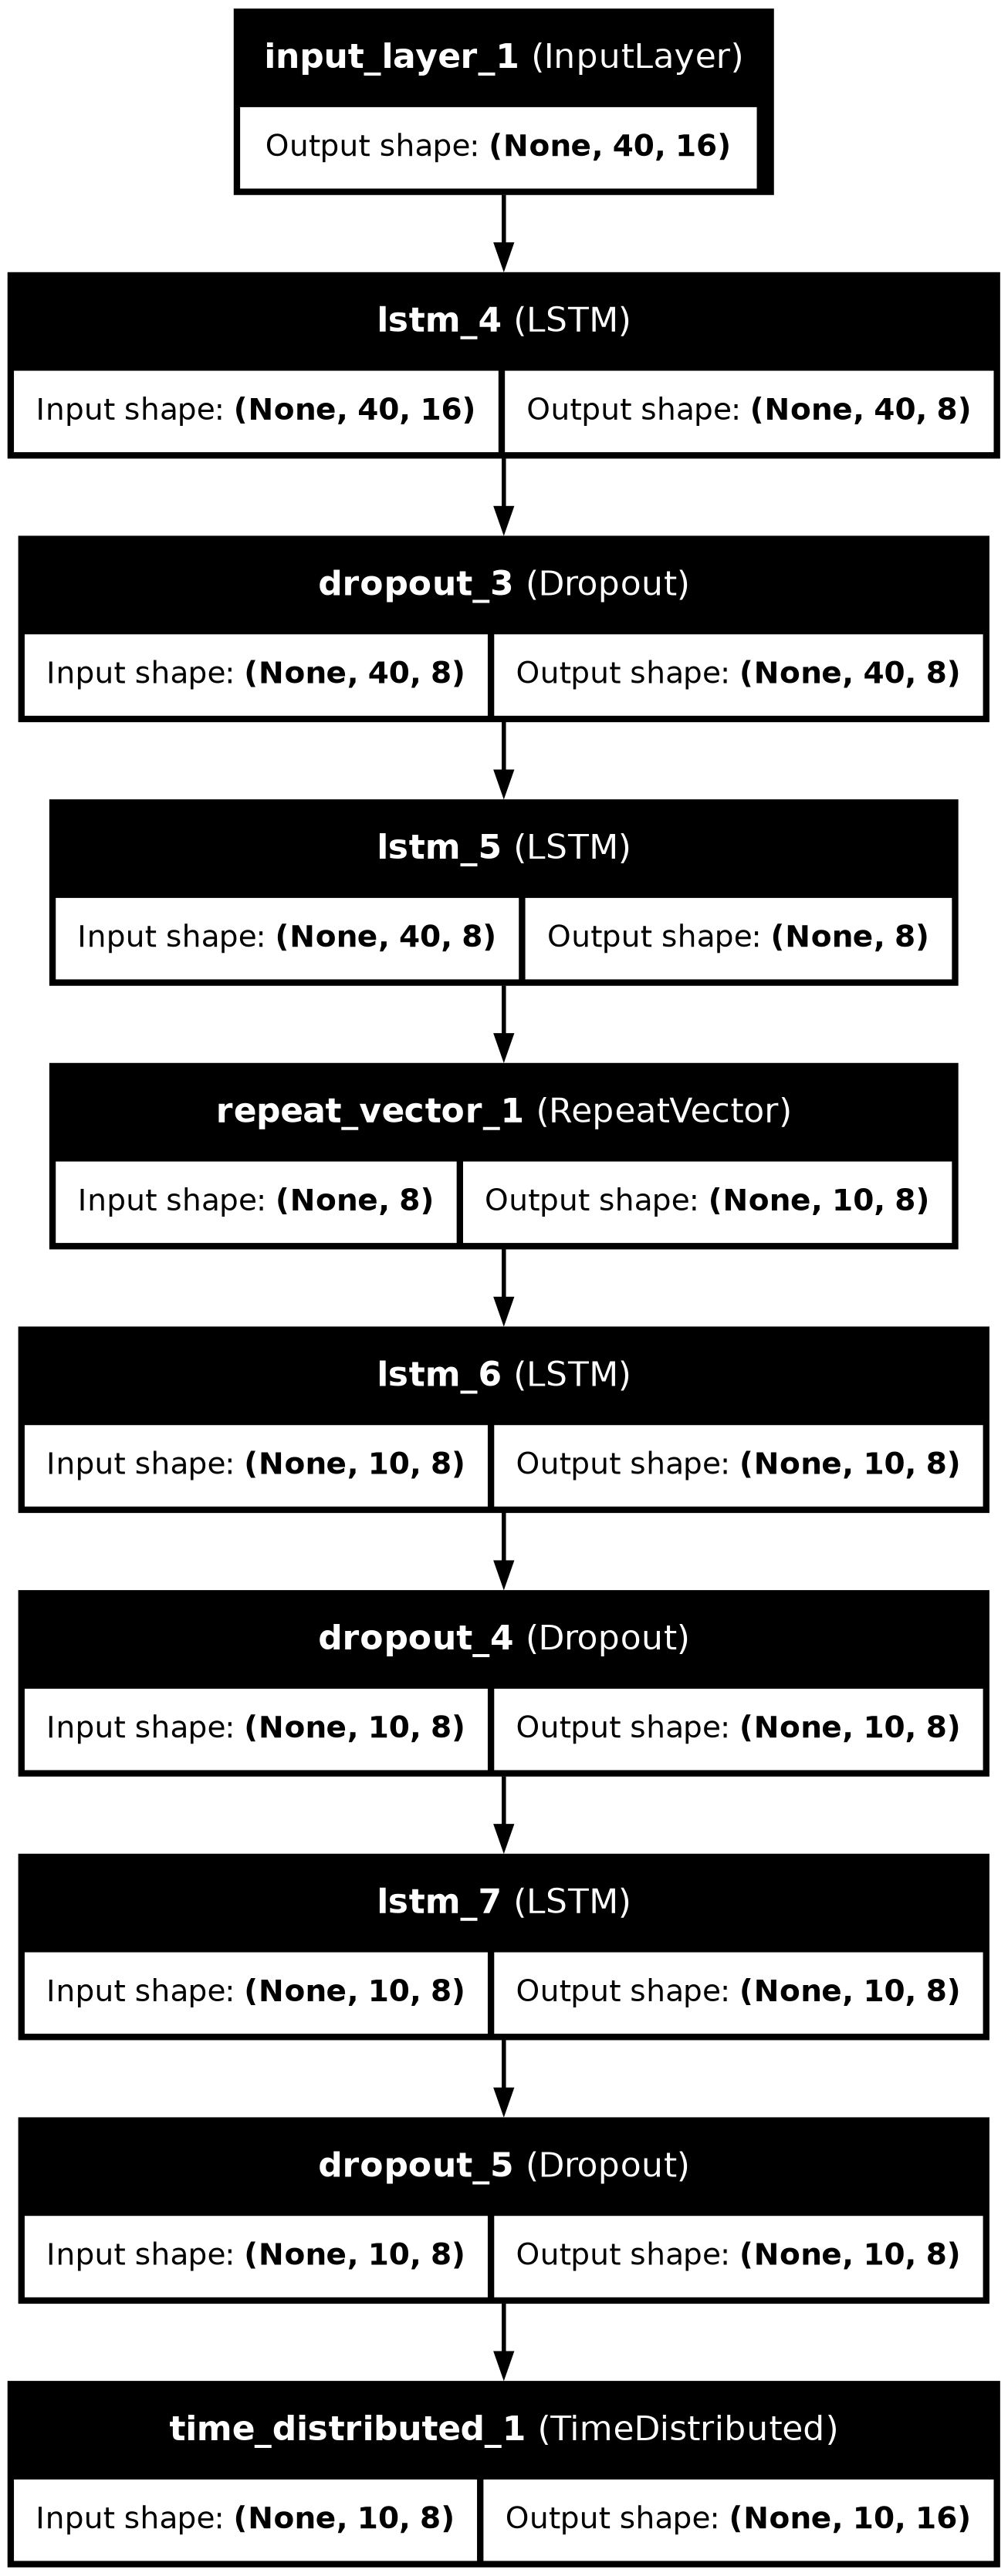

In [5]:
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(encoder_decoder_model, to_file='EncoderDecoder.png', show_shapes=True, show_layer_names=True)

# Display theEncoderDecoder plot inline (for Jupyter Notebooks)
from IPython.display import Image
Image('EncoderDecoder.png')

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset1/log_14_2024-3-23-15-36-52 (1).csv"

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# Load the trained model
# model = load_model('/kaggle/working/trained_model.h5')

# Make predictions
y_pred = encoder_decoder_model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")


1714/1714 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Mean Squared Error (MSE): 423.36746950963874
R-squared (R²) score: 0.9999990864701279


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset/log_55_2024-2-26-13-11-52.csv"
n_past = 10
n_future = 1

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler()
data_scaled_test = scaler.fit_transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# Predict using the model
y_pred = encoder_decoder_model.predict(X_test)

# Reshape y_test to match the prediction shape
y_test_reshaped = y_test.reshape(y_test.shape[0] * y_test.shape[1], y_test.shape[2])
y_pred_reshaped = y_pred.reshape(y_pred.shape[0] * y_pred.shape[1], y_pred.shape[2])

# Calculate MSE and R2 Score
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
r2 = r2_score(y_test_reshaped, y_pred_reshaped)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")


Attenstion

In [7]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, AdditiveAttention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"
# n_past = 100
# n_future = 10
# batch_size = 60  # Set batch size
# epochs = 20

# Define the encoder-decoder model with attention
def create_encoder_decoder_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    encoder_lstm1 = LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(inputs)
    encoder_dropout1 = Dropout(0.2)(encoder_lstm1)
    encoder_lstm2 = LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(encoder_dropout1)
    encoder_dropout2 = Dropout(0.2)(encoder_lstm2)
    
    # Context vector for attention
    context = LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(encoder_dropout2)
    context_dropout = Dropout(0.2)(context)
    
    # Decoder
    decoder_inputs = Input(shape=(n_future, 10))  # Define shape for decoder input
    decoder_lstm1 = LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(decoder_inputs)
    decoder_dropout1 = Dropout(0.2)(decoder_lstm1)
    
    # Apply Attention
    attention = AdditiveAttention()([decoder_dropout1, context_dropout])
    
    # Combine context and attention output
    combined = Concatenate(axis=-1)([attention, decoder_dropout1])
    
    decoder_lstm2 = LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform())(combined)
    decoder_dropout2 = Dropout(0.2)(decoder_lstm2)
    decoder_outputs = TimeDistributed(Dense(input_shape[1], kernel_initializer=GlorotUniform()))(decoder_dropout2)
    
    # Define the model
    encoder_decoder_attention_model = Model(inputs=[inputs, decoder_inputs], outputs=decoder_outputs)
    encoder_decoder_attention_model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse')
    
    return encoder_decoder_attention_model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    
    # Prepare decoder input (usually starting with zeros)
    decoder_input_data = np.zeros((X.shape[0], n_future, 10))  # Shape: (number of samples, future timesteps, features)
    
    while cnt == 1:
        # Create and train the model
        encoder_decoder_attention_model = create_encoder_decoder_attention_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    # Train the model
    encoder_decoder_attention_model.fit([X, decoder_input_data], y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
    print(f"Model training complete for {file}")

print("Processing complete.")


Processing /kaggle/input/trainingdata/log_49_2024-2-26-12-50-54.csv
Epoch 1/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - loss: 4.6814 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 2/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.2790 - val_loss: 0.4349 - learning_rate: 0.0010
Model training complete for /kaggle/input/trainingdata/log_49_2024-2-26-12-50-54.csv
Processing /kaggle/input/trainingdata/log_54_2024-2-26-13-10-12.csv
Epoch 1/2
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - loss: 280.7600 - val_loss: 2.7804 - learning_rate: 0.0010
Epoch 2/2
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 35.5169 - val_loss: 2.7570 - learning_rate: 0.0010
Model training complete for /kaggle/input/trainingdata/log_54_2024-2-26-13-10-12.csv
Processing /kaggle/input/trainingdata/log_51_2024-2-26-12-53-18.csv
Epoch 1/2
452/452 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 17.7951 - val_loss: 0.3770 - learning_rate: 0.0010
Epoch 2/2
452/452 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.64

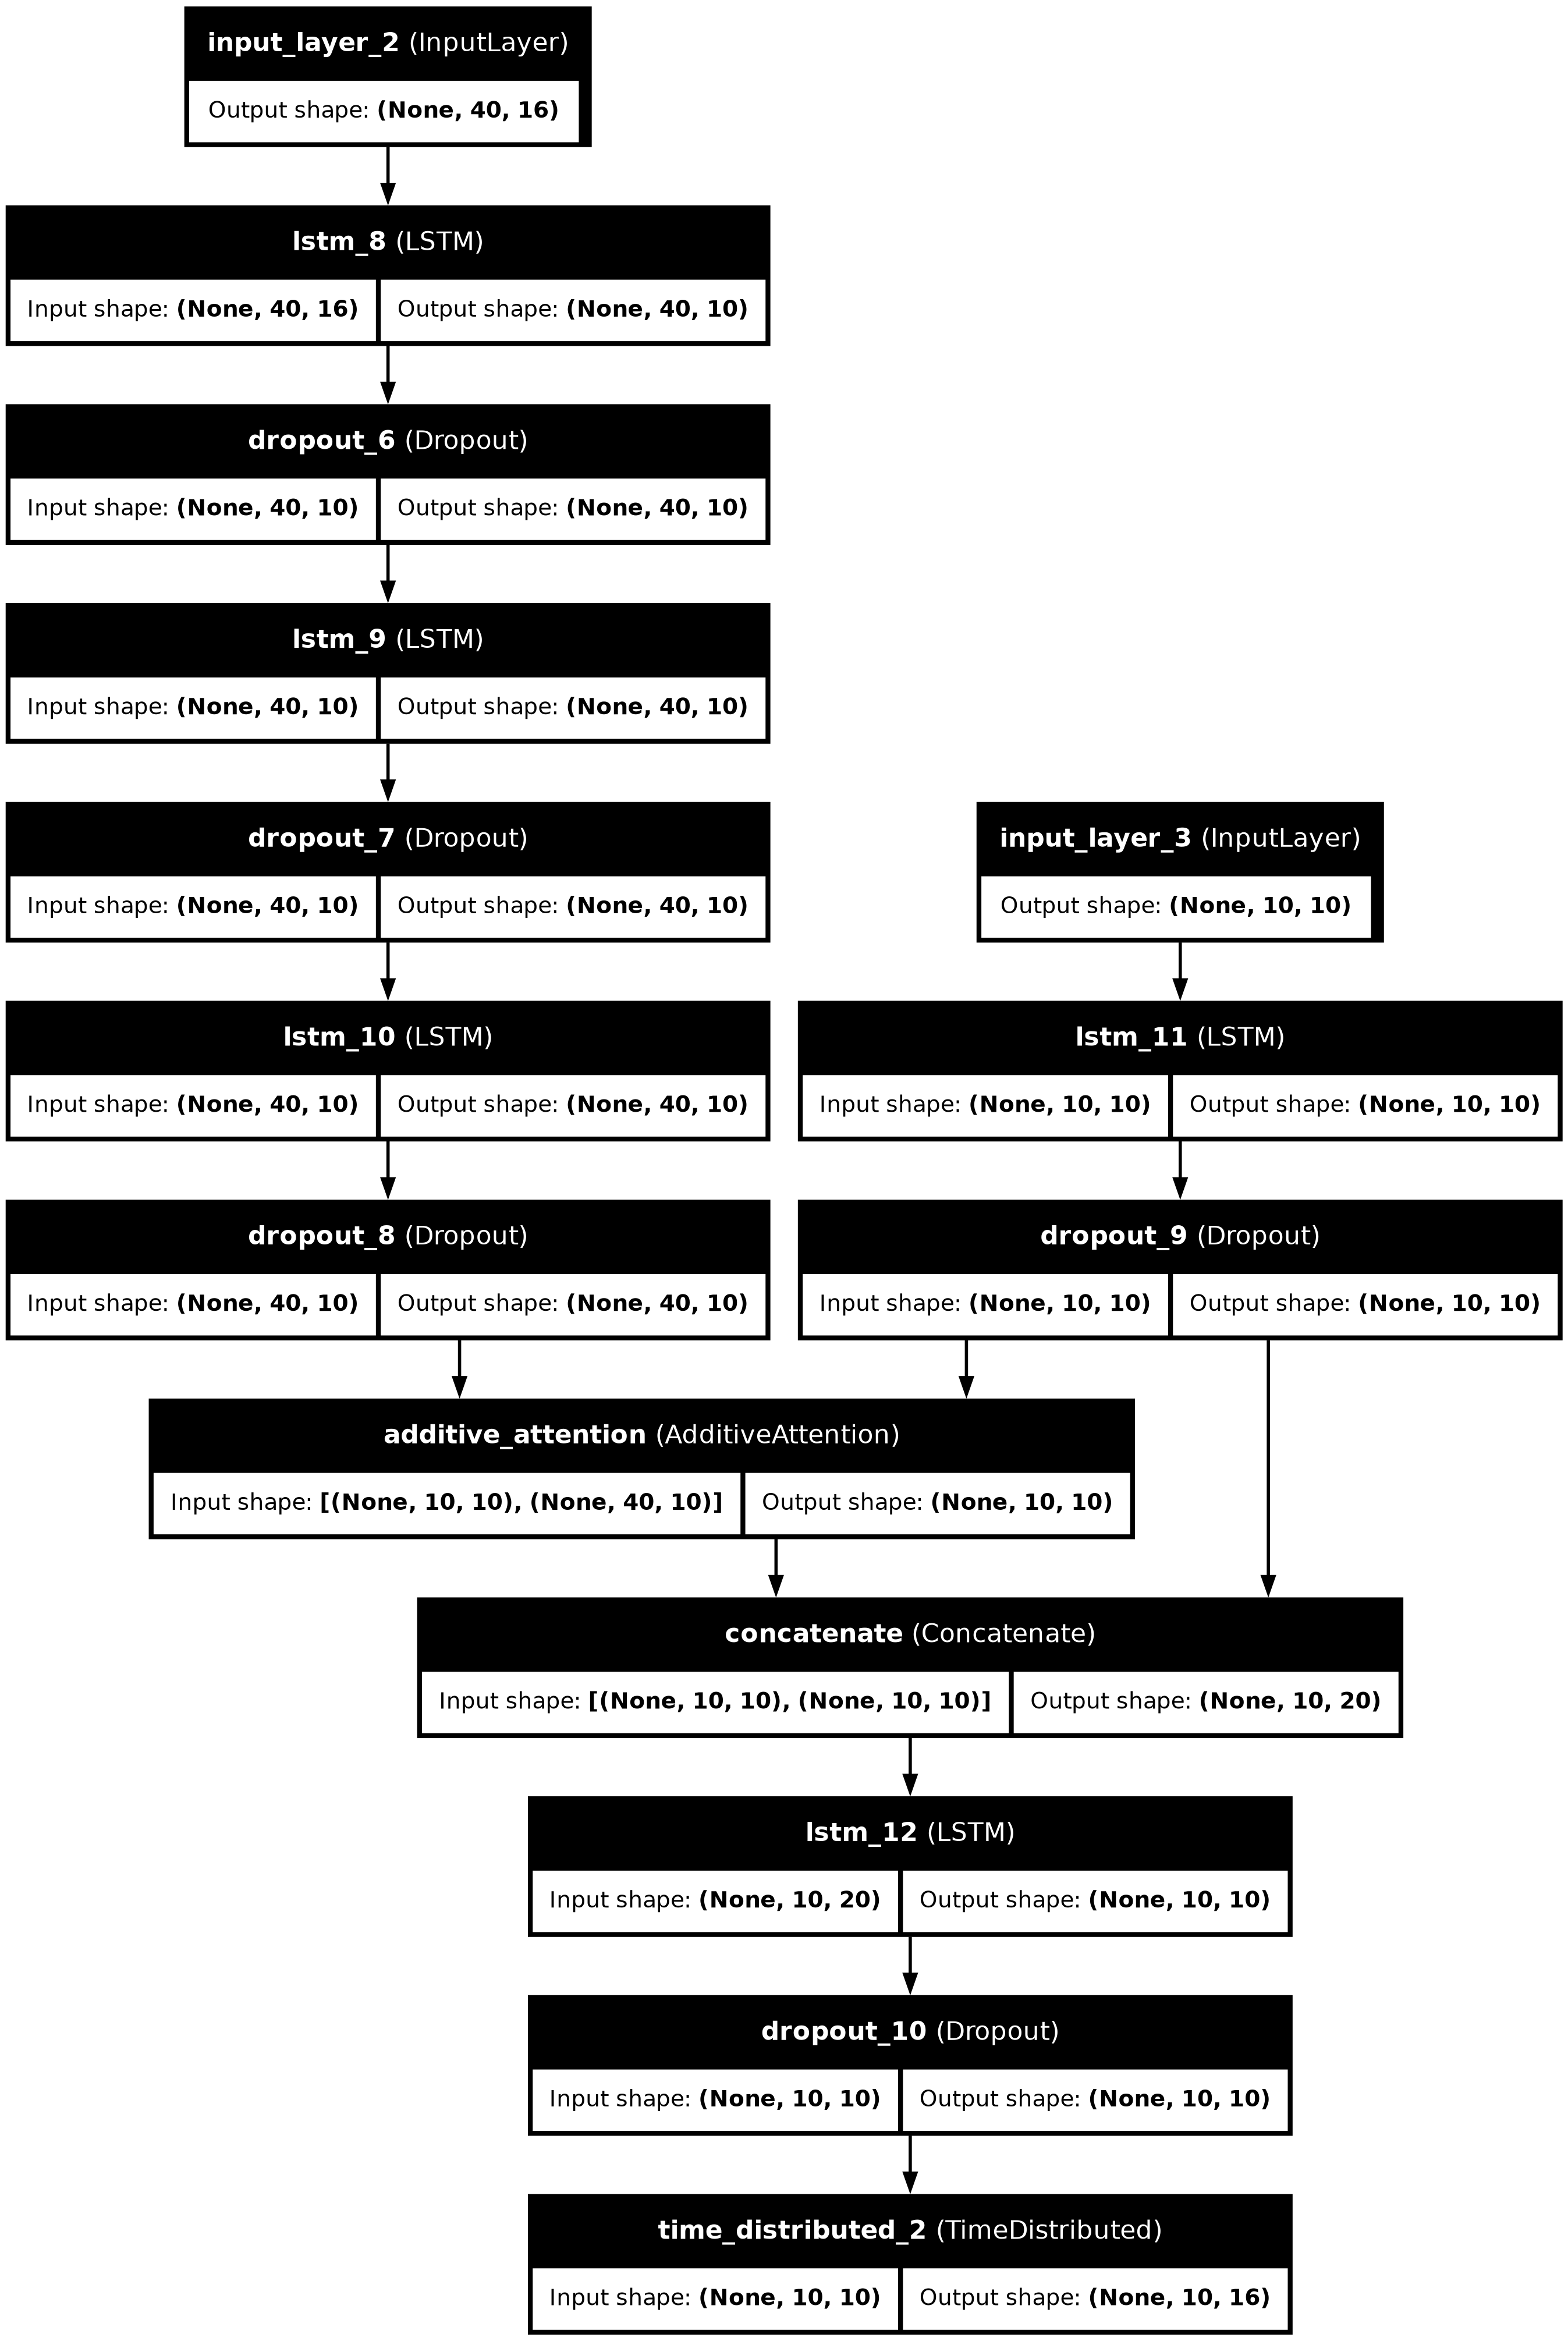

In [8]:
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(encoder_decoder_attention_model, to_file='encoder_decoder_attention_model.png', show_shapes=True, show_layer_names=True)

# Display theEncoderDecoder plot inline (for Jupyter Notebooks)
# from IPython.display import Image
# Image('EncoderDecoder.png')

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset1/log_14_2024-3-23-15-36-52 (1).csv"

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler().fit(df_test)
data_scaled_test = scaler.transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# Load the trained model
# model = load_model('/kaggle/working/trained_model.h5')

# Make predictions
y_pred = encoder_decoder_attention_model.predict(X_test)

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Inverse transform the y_test and y_pred
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) score: {r2}")


ValueError: Layer "functional_2" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(32, 40, 16) dtype=float32>]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset/log_55_2024-2-26-13-11-52.csv"
# n_past = 10
# n_future = 1

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler()
data_scaled_test = scaler.fit_transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# Prepare decoder input data
decoder_input_data = np.zeros((X_test.shape[0], n_future, 10))  # Adjust based on the feature dimension

# Load the trained model (replace 'path_to_your_model.h5' with your model file if necessary)
# encoder_decoder_attention_model = load_model('path_to_your_model.h5')

# Predict using the model
y_pred = encoder_decoder_attention_model.predict([X_test, decoder_input_data])

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[2])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[2])

# Calculate MSE and R2 Score
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
r2 = r2_score(y_test_reshaped, y_pred_reshaped)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")


In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, AdditiveAttention, Concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths and parameters
data_folder = "/kaggle/input/trainingdata/*.csv"
n_past = 10
n_future = 1
batch_size = 64  # Experiment with different batch sizes
epochs = 30  # Increase epochs for better training

# Define the encoder-decoder model with attention and Bidirectional LSTM
def create_encoder_decoder_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    encoder_lstm1 = Bidirectional(LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()))(inputs)
    encoder_dropout1 = Dropout(0.3)(encoder_lstm1)  # Adjust dropout rate
    encoder_lstm2 = Bidirectional(LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()))(encoder_dropout1)
    encoder_dropout2 = Dropout(0.3)(encoder_lstm2)
    
    # Context vector for attention
    context = Bidirectional(LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()))(encoder_dropout2)
    context_dropout = Dropout(0.3)(context)
    
    # Decoder
    decoder_inputs = Input(shape=(n_future, input_shape[1]))  # Adjust shape for decoder input
    decoder_lstm1 = Bidirectional(LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()))(decoder_inputs)
    decoder_dropout1 = Dropout(0.3)(decoder_lstm1)
    
    # Apply Attention
    attention = AdditiveAttention()([decoder_dropout1, context_dropout])
    
    # Combine context and attention output
    combined = Concatenate(axis=-1)([attention, decoder_dropout1])
    
    decoder_lstm2 = Bidirectional(LSTM(10, activation='relu', return_sequences=True, kernel_initializer=GlorotUniform()))(combined)
    decoder_dropout2 = Dropout(0.3)(decoder_lstm2)
    decoder_outputs = TimeDistributed(Dense(input_shape[1], kernel_initializer=GlorotUniform()))(decoder_dropout2)
    
    # Define the model
    encoder_decoder_attention_model = Model(inputs=[inputs, decoder_inputs], outputs=decoder_outputs)
    encoder_decoder_attention_model.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=1.0), loss='mse')  # Adjust learning rate
    
    return encoder_decoder_attention_model

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

cnt = 1
# Process each CSV file individually
for file in glob.glob(data_folder):
    print(f"Processing {file}")
    
    # Load and preprocess data
    df = pd.read_csv(file)
    df = df.iloc[:, 1:]  # Drop the first column
    data_scaled = RobustScaler().fit_transform(df)  # Use RobustScaler for each file individually
    
    # Create sequences
    X, y = create_sequences(data_scaled, n_past, n_future)
    
    # Prepare decoder input (usually starting with zeros)
    decoder_input_data = np.zeros((X.shape[0], n_future, X.shape[2]))  # Shape: (number of samples, future timesteps, features)
    
    while cnt == 1:
    # Create and train the model
        encoder_decoder_attention_model = create_encoder_decoder_attention_model((n_past, data_scaled.shape[1]))
        cnt = cnt - 1
    # Callbacks for training
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Adjust patience
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)  # Adjust patience
    
    # Train the model
    encoder_decoder_attention_model.fit([X, decoder_input_data], y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    
    print(f"Model training complete for {file}")

print("Processing complete.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Define paths and parameters
test_file = "/kaggle/input/testingdataset/log_55_2024-2-26-13-11-52.csv"
n_past = 10
n_future = 1

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    num_samples = len(data) - n_past - n_future + 1
    for i in range(num_samples):
        X.append(data[i: i + n_past, :])
        y.append(data[i + n_past: i + n_past + n_future, :])
    return np.array(X), np.array(y)

# Load and preprocess test data
df_test = pd.read_csv(test_file)
df_test = df_test.iloc[:, 1:]  # Drop the first column
scaler = RobustScaler()
data_scaled_test = scaler.fit_transform(df_test)

# Create sequences
X_test, y_test = create_sequences(data_scaled_test, n_past, n_future)

# Prepare decoder input (usually starting with zeros)
decoder_input_data = np.zeros((X_test.shape[0], n_future, X_test.shape[2]))

# Load the trained model (if needed)
# Replace 'path_to_your_model.h5' with the path where your model is saved
# encoder_decoder_attention_model = load_model('path_to_your_model.h5')

# Predict using the model
y_pred = encoder_decoder_attention_model.predict([X_test, decoder_input_data])

# Reshape y_test and y_pred to match the prediction shape
y_test_reshaped = y_test.reshape(y_test.shape[0] * y_test.shape[1], y_test.shape[2])
y_pred_reshaped = y_pred.reshape(y_pred.shape[0] * y_pred.shape[1], y_pred.shape[2])

# Calculate MSE and R2 Score
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
r2 = r2_score(y_test_reshaped, y_pred_reshaped)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
